In [1]:
import pandas as pd
import numpy as np
from numpy.lib.format import open_memmap
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score

### Imports

### Generate Data

In [2]:
def initialize_sample_memmap_npy():
    ref = pd.read_csv('data/patient_timepoints.csv', dtype={'patient_id': str, 'timepoint': int})

    feature_cols = ref.columns[2:]
    # Scale data with Pareto scaling
    feat_df = ref[feature_cols].astype(float)
    feat_df = feat_df.div(np.sqrt(feat_df.std()), axis=1)
    feat_df = feat_df.div(feat_df.sum(axis=1), axis=0)

    # Replace NA's with 0
    feat_df = feat_df.fillna(0.0)

    # Build lookup on scaled vectors
    sample_dict = {
        (row['patient_id'].lstrip('0'), row['timepoint']): 
           feat_df.iloc[i].to_numpy(dtype=np.float32)
        for i, row in ref.iterrows()
    }

    for split in ('train','val','test'):
        pairs = pd.read_csv(f'data/{split}_pair_keys.csv',
                            dtype={'patient_id_a':str,'timepoint_a':int,
                                   'patient_id_b':str,'timepoint_b':int})
        n = len(pairs)
        feature_dim = len(feature_cols)

        X_mm = open_memmap(f'data/{split}_scaled_X.npy', mode='w+', dtype='float32',
                           shape=(n, feature_dim))
        y_mm = open_memmap(f'data/{split}_scaled_y.npy', mode='w+', dtype='int8',
                           shape=(n,))

        for i, row in enumerate(pairs.itertuples(index=False)):
            a, ta = row.patient_id_a.lstrip('0'), row.timepoint_a
            b, tb = row.patient_id_b.lstrip('0'), row.timepoint_b
            vec_a = sample_dict[(a, ta)]
            vec_b = sample_dict[(b, tb)]
            X_mm[i] = np.abs(vec_a - vec_b)
            y_mm[i] = 1 if a == b else 0

        X_mm.flush(); y_mm.flush()
        print(f"{split} data built: {X_mm.shape}")

initialize_sample_memmap_npy()

train data built: (26106, 40921)
val data built: (11935, 40921)
test data built: (8629, 40921)


### Load Data

In [3]:
# Load key files to get sizes and feature dimension
ref = pd.read_csv('data/patient_timepoints.csv', dtype={'patient_id':str,'timepoint':int})
feature_dim = ref.shape[1] - 2

train_pairs = pd.read_csv('data/train_pair_keys.csv', dtype={'patient_id_a':str,'timepoint_a':int,'patient_id_b':str,'timepoint_b':int})
val_pairs   = pd.read_csv('data/val_pair_keys.csv',   dtype=train_pairs.dtypes.to_dict())
test_pairs  = pd.read_csv('data/test_pair_keys.csv',  dtype=train_pairs.dtypes.to_dict())

n_train = len(train_pairs)
n_val   = len(val_pairs)
n_test  = len(test_pairs)

# Memory-map the data
train_X = np.load('data/train_scaled_X.npy', mmap_mode='r')
train_y = np.load('data/train_scaled_y.npy', mmap_mode='r')
val_X   = np.load('data/val_scaled_X.npy',   mmap_mode='r')
val_y   = np.load('data/val_scaled_y.npy',   mmap_mode='r')
test_X  = np.load('data/test_scaled_X.npy',  mmap_mode='r')
test_y  = np.load('data/test_scaled_y.npy',  mmap_mode='r')

In [4]:
# count the number of positive and negative samples
pos_count = np.sum(train_y)
neg_count = n_train - pos_count
print(f"Train set: {n_train} samples, {pos_count} positives, {neg_count} negatives")

# validation set
val_pos_count = np.sum(val_y)
val_neg_count = n_val - val_pos_count
print(f"Validation set: {n_val} samples, {val_pos_count} positives, {val_neg_count} negatives")

# test set
test_pos_count = np.sum(test_y)
test_neg_count = n_test - test_pos_count
print(f"Test set: {n_test} samples, {test_pos_count} positives, {test_neg_count} negatives")

Train set: 26106 samples, 624 positives, 25482 negatives
Validation set: 11935 samples, 189 positives, 11746 negatives
Test set: 8629 samples, 111 positives, 8518 negatives


### Train Model

In [14]:
# Logistic Regression model
clf = SGDClassifier(
    loss='huber',
    penalty='l1',
    max_iter=1,
    learning_rate='optimal',
    warm_start=True,
    random_state=42
)

batch_size = 64
epochs = 5
classes    = np.unique(train_y)
negative_weight = 0.20
positive_weight = 2.0
sample_weight = np.where(train_y == 1, positive_weight, negative_weight)
# # Mini‐batch training
for epoch in range(epochs):
    for start in range(0, n_train, batch_size):
        end = min(start + batch_size, n_train)
        Xb = train_X[start:end]
        yb = train_y[start:end]
        if epoch == 0 and start == 0:
            clf.partial_fit(Xb, yb, classes=classes, sample_weight=sample_weight[start:end])
        else:
            clf.partial_fit(Xb, yb, sample_weight=sample_weight[start:end])
    print(f"Epoch {epoch+1}/10 finished")



for name, X, y in [('Train', train_X, train_y),
                  ('Val',   val_X,   val_y),
                  ('Test',  test_X,  test_y)]:
    pred = clf.predict(X)
    acc   = accuracy_score(y, pred)
    recall = np.sum((y == 1) & (pred == 1)) / np.sum(y == 1)
    precision = np.sum((y == 1) & (pred == 1)) / np.sum(pred == 1)
    fpr = np.sum((y == 0) & (pred == 1)) / np.sum(y == 0)
    f1    = f1_score(y, pred, average='weighted')
    print(f"{name:5} → Acc: {acc:.4f}, F1: {f1:.4f}, recall: {recall:.4f}, precision: {precision:.4f}, fpr: {fpr:.4f}")

Epoch 1/10 finished
Epoch 2/10 finished
Epoch 3/10 finished
Epoch 4/10 finished
Epoch 5/10 finished
Train → Acc: 0.9761, F1: 0.9643, recall: 0.0000, precision: nan, fpr: 0.0000


/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_51449/1740403382.py:37: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.sum((y == 1) & (pred == 1)) / np.sum(pred == 1)
/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_51449/1740403382.py:37: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.sum((y == 1) & (pred == 1)) / np.sum(pred == 1)


Val   → Acc: 0.9842, F1: 0.9763, recall: 0.0000, precision: nan, fpr: 0.0000
Test  → Acc: 0.9871, F1: 0.9807, recall: 0.0000, precision: nan, fpr: 0.0000


/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_51449/1740403382.py:37: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.sum((y == 1) & (pred == 1)) / np.sum(pred == 1)


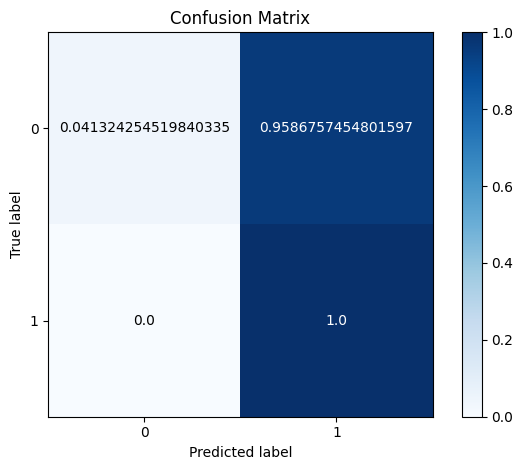

In [9]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches       


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = cm.astype('int')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    fig.colorbar(im)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax.text(j, i, f'{cm[i, j]}', ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.show()
plot_confusion_matrix(test_y, pred, classes=classes, normalize=True)

### Inspect features

In [14]:
# View top peptidoform features
num_feats = 20
coefs = np.abs(clf.coef_).ravel()
top20 = np.argsort(coefs)[::-1][:num_feats]
print("Top 20 features:")
for idx in top20:
    print(f"  Feature {idx}: coef={clf.coef_.ravel()[idx]:.4f}")

Top 20 features:
  Feature 19135: coef=-1.4621
  Feature 19589: coef=-0.5871
  Feature 14798: coef=-0.4500
  Feature 21052: coef=-0.3893
  Feature 23557: coef=-0.0374
  Feature 10894: coef=-0.0252
  Feature 16044: coef=-0.0185
  Feature 15356: coef=-0.0178
  Feature 31511: coef=-0.0169
  Feature 6464: coef=-0.0153
  Feature 30656: coef=-0.0098
  Feature 17894: coef=-0.0074
  Feature 23346: coef=-0.0074
  Feature 9185: coef=-0.0068
  Feature 31145: coef=-0.0062
  Feature 21307: coef=-0.0061
  Feature 9329: coef=-0.0061
  Feature 11954: coef=-0.0059
  Feature 18511: coef=-0.0055
  Feature 40531: coef=-0.0054
